# Cis-eQTL Module QTL Colocalization

**Created**: 2 May 2022

## Environment

In [1]:
library(tidyverse)
library(data.table)
library(coloc)
library(GenomicRanges)

setwd("~/eQTL_pQTL_Characterization/")

source("01_Colocalization/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is coloc version 5.1.1

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clu

## Load Summary Information

Load summary statistics from conditional analysis performed using COJO. Only use cis-eQTL that have the same lead eSNP.

In [2]:
geno.bim <- fread("/nfs/users/nfs_n/nm18/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")

colnames(geno.bim) <- c("chr", "snp", "cM", "pos", "minor_allele", "major_allele")

In [3]:
head(geno.bim)

chr,snp,cM,pos,minor_allele,major_allele
<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,rs3131972,0,817341,A,G
1,rs546843995,0,818053,0,G
1,rs553916047,0,818359,0,A
1,1:818740_T_C,0,818740,T,C
1,rs145604921,0,819378,0,C
1,rs535256652,0,821053,0,T


In [4]:
module.ss.dir = "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/eigengene_sva/wgcna_summary_statistics/"
module.qtl <- do.call(rbind, lapply(list.files(module.ss.dir, pattern="ME.*\\.tsv"), function(file.name) {

    fread(paste0(module.ss.dir, file.name)) %>%
        as.data.frame() %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5) %>%
        dplyr::mutate(module.qtl=gsub("\\.tsv", "", file.name)) %>%
        dplyr::mutate(module=gsub("-.*$", "", module.qtl)) %>%
        dplyr::mutate(qtl.locus=gsub("ME\\_\\d+-", "", module.qtl)) %>%
        dplyr::mutate(qtl.locus.chr=gsub("\\:.*", "", qtl.locus)) %>%
        dplyr::mutate(qtl.locus.start=as.numeric(gsub(".*\\:", "", gsub("-.*$", "", qtl.locus)))) %>%
        dplyr::mutate(qtl.locus.end=as.numeric(gsub(".*-", "", qtl.locus)))
})) %>%
    merge(., geno.bim, by="snp")

In [5]:
head(module.qtl)

,snp,beta,se,t,p,module.qtl,module,qtl.locus,qtl.locus.chr,qtl.locus.start,qtl.locus.end,chr,cM,pos,minor_allele,major_allele
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>
1,rs10000051,-0.002533637,0.0012124174,-2.089740,3.691116e-02,ME_86-4:118205924-120759794,ME_86,4:118205924-120759794,4,118205924,120759794,4,0,120370537,T,C
2,rs10000337,-0.003054827,0.0013318854,-2.293611,2.206027e-02,ME_86-4:118205924-120759794,ME_86,4:118205924-120759794,4,118205924,120759794,4,0,119914524,C,G
3,rs10000465,0.002650209,0.0022813072,1.161706,2.457148e-01,ME_86-4:118205924-120759794,ME_86,4:118205924-120759794,4,118205924,120759794,4,0,119914659,A,G
4,rs10000544,0.011442289,0.0008438905,13.558973,5.330653e-37,ME_86-4:118205924-120759794,ME_86,4:118205924-120759794,4,118205924,120759794,4,0,119349550,A,G
5,rs10000675,0.003270617,0.0008990014,3.638056,2.931574e-04,ME_86-4:118205924-120759794,ME_86,4:118205924-120759794,4,118205924,120759794,4,0,120599469,A,C
6,rs10000726,-0.004771351,0.0011746773,-4.061840,5.450012e-05,ME_86-4:118205924-120759794,ME_86,4:118205924-120759794,4,118205924,120759794,4,0,119289609,G,A


In [6]:
module.qtl.ranges <- module.qtl %>%
    dplyr::select(chr=qtl.locus.chr, start=qtl.locus.start, end=qtl.locus.end, module.qtl) %>%
    unique() %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

In [7]:
cis.eqtl.summary <- do.call(rbind, lapply(unique(module.qtl$qtl.locus.chr), function(chr) {
    eqtl.ss = fread(paste0("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LD/chr", chr, "_conditional_cis_eQTL_summary_statistics.tsv")) %>%
        as.data.frame() %>%
        dplyr::mutate(ID=paste0(Gene, "-", Signal))
    
    eqtl.ss.ranges = eqtl.ss %>%
        makeGRangesFromDataFrame(seqnames.field="Chr", start.field="Position", end.field="Position", keep.extra.columns=TRUE)
    
    overlaps = findOverlaps(eqtl.ss.ranges, module.qtl.ranges)
    
    result = eqtl.ss[overlaps@from, ]
    result$Module.QTL = mcols(module.qtl.ranges)$module.qtl[overlaps@to]
    
    return(result)
}))

In [8]:
head(cis.eqtl.summary)

,Gene,Signal,Chr,SNP,Position,Beta,SE,P_Value,ID,Module.QTL
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
232260,ENSG00000138735,1,4,rs10000051,120370537,-0.02463591,0.02288245,2.818524e-01,ENSG00000138735-1,ME_86-4:118205924-120759794
232261,ENSG00000138735,1,4,rs10000337,119914524,-0.06180665,0.02488308,1.332365e-02,ENSG00000138735-1,ME_86-4:118205924-120759794
232262,ENSG00000138735,1,4,rs10000465,119914659,-0.03708470,0.04250645,3.833530e-01,ENSG00000138735-1,ME_86-4:118205924-120759794
232263,ENSG00000138735,1,4,rs10000544,119349550,0.16610479,0.01664458,1.007565e-21,ENSG00000138735-1,ME_86-4:118205924-120759794
232264,ENSG00000138735,1,4,rs10000675,120599469,0.01148459,0.01704141,5.006335e-01,ENSG00000138735-1,ME_86-4:118205924-120759794
232265,ENSG00000138735,1,4,rs10000726,119289609,-0.08890957,0.02192357,5.640724e-05,ENSG00000138735-1,ME_86-4:118205924-120759794


Split summary statistics by locus.

In [9]:
cis.eqtl.loci <- split(cis.eqtl.summary, cis.eqtl.summary$Module.QTL) %>%
    lapply(., function(x) { split(x, x$ID) })

In [10]:
module.qtl.loci <- split(module.qtl, module.qtl$module.qtl)

## Load Gene Expression and Module Eigengenes

In [11]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt")
gene.exp <- t(gene.exp)
rownames(gene.exp) <- gsub("^GA", "", rownames(gene.exp))

In [12]:
head(gene.exp)

,ENSG00000230521,ENSG00000225864,ENSG00000227766,ENSG00000237669,ENSG00000271581,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000227262,ENSG00000206337,⋯,ENSG00000288253,ENSG00000288302,ENSG00000288349,ENSG00000288393,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
UK02270173_3,0.6644339,0.9817872,1.2117156,0.6420763,2.474490,0.00000000,3.704888,4.027339,0.06866465,7.318038,⋯,0.5247755,1.3000450,0.5247755,0.92735960,1.133738,1.1337380,0.9457312,0.87079780,0.31467050,2.811486
UK15130120_3,0.5827160,0.4387994,0.3068267,0.6925683,1.331531,0.03379072,4.261280,3.634898,0.25046090,6.369198,⋯,0.5125515,1.7424980,0.4883840,0.06680807,1.860177,0.6496258,0.9264084,0.06680807,0.22143010,3.343063
UK58000006_3,0.4046756,0.6022344,0.6625010,0.9792012,1.831046,0.00000000,3.719682,3.597655,0.00000000,6.837021,⋯,0.2947282,1.5250610,0.6326824,0.66250100,1.315821,1.4755270,1.0258310,0.29472820,0.13374420,4.010874
UK47010004_3,0.2090516,0.9234049,0.7996329,0.6992958,2.475317,0.05517067,4.169617,3.016982,0.30321616,7.723203,⋯,0.3032162,0.9527571,1.0911770,0.30321620,1.143029,1.8370600,0.7669565,0.25690200,0.10830900,2.610379
UK42020088_5,0.2211571,0.2211571,0.6445686,0.3765156,1.881204,0.67482702,4.527758,3.624300,0.04702687,6.350747,⋯,0.0925691,1.2174450,0.6748270,0.13671760,1.088510,2.0637890,0.8172741,0.04702687,0.22115710,2.434768
UK47490007_3,0.4288519,1.1450686,0.3130290,1.0756817,2.053137,0.00000000,4.581986,3.101136,0.00000000,6.728267,⋯,0.5012039,1.9916780,1.1895390,0.35267880,1.211271,0.7590055,0.6033524,1.02749800,0.09657541,3.816079


In [13]:
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)

In [14]:
head(eigengenes)

,ME_1,ME_2,ME_3,ME_4,ME_5,ME_6,ME_7,ME_8,ME_9,ME_10,⋯,ME_97,ME_98,ME_99,ME_100,ME_101,ME_102,ME_103,ME_104,ME_105,ME_106
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK02270173_3,0.008640296,0.007926439,0.0147219682,-0.011774847,0.029042358,-0.006588595,-0.004034583,-0.013647582,0.020445938,0.03657146,⋯,0.105461618,0.014671996,-0.03186240,-0.019044546,-0.001067989,0.03791366,0.008340969,-0.002505741,0.033258706,-0.003317747
UK15130120_3,-0.037073495,-0.033179470,-0.0311931107,-0.006189163,0.039065099,-0.011809051,0.037283445,-0.060021257,-0.036280957,0.03133065,⋯,-0.006444524,-0.019642856,0.01880373,-0.044684726,-0.043663066,-0.02550290,0.031624201,-0.011931533,0.051184001,-0.012327128
UK58000006_3,0.029670524,0.021490110,0.0369543066,-0.015010027,-0.004745170,0.023133390,-0.027585817,0.010804862,0.044649369,-0.01014143,⋯,0.085257258,-0.006499496,-0.01582150,0.030709065,0.040952839,0.04332857,-0.003376643,0.012633897,-0.006622840,-0.004740631
UK47010004_3,0.011954974,0.007360515,0.0073725862,-0.011608271,-0.011341294,-0.025127169,-0.009500677,0.013387153,0.007126337,-0.02607067,⋯,0.075920669,-0.016223383,0.02515734,-0.008023902,0.018023055,-0.01461801,0.010948287,0.023381207,-0.003072117,0.012014706
UK42020088_5,0.009818957,0.008322535,0.0004121376,-0.008882007,-0.028000468,0.002082996,-0.009532910,0.011477800,-0.001521594,-0.02223628,⋯,0.035896079,0.009274050,0.03406072,-0.005459722,0.037120618,-0.01089588,-0.008355454,-0.034402696,-0.032697222,0.007915598
UK47490007_3,-0.021930377,-0.024756322,-0.0294342468,-0.007742353,-0.005486842,-0.049842615,0.020825112,0.007441717,-0.030615907,-0.01853294,⋯,0.092538453,0.067616309,0.02790283,-0.036887001,-0.017742254,0.01562787,0.026717734,-0.009877409,-0.003607270,0.024871961


## COLOC

In [15]:
coloc.res <- do.call(rbind, lapply(names(module.qtl.loci), function(module.qtl.id) {

    do.call(rbind, lapply(names(cis.eqtl.loci[[module.qtl.id]]), function(cis.eqtl.id) {
    
        cis.eqtl.loci[[module.qtl.id]][[cis.eqtl.id]] <- cis.eqtl.loci[[module.qtl.id]][[cis.eqtl.id]] %>%
            dplyr::filter(!is.na(Beta))

        gene = gsub("-.*", "", cis.eqtl.id)
        me = gsub("-.*", "", module.qtl.id)

        cis.eqtl <- list()
        cis.eqtl$beta <- cis.eqtl.loci[[module.qtl.id]][[cis.eqtl.id]]$Beta
        cis.eqtl$varbeta <- cis.eqtl.loci[[module.qtl.id]][[cis.eqtl.id]]$SE^2
        cis.eqtl$snp <- cis.eqtl.loci[[module.qtl.id]][[cis.eqtl.id]]$SNP
        cis.eqtl$position <- cis.eqtl.loci[[module.qtl.id]][[cis.eqtl.id]]$Position
        cis.eqtl$type <- "quant"
        cis.eqtl$sdY <- sd(gene.exp[, gene], na.rm=TRUE)

        module.qtl <- list()
        module.qtl$beta <- module.qtl.loci[[module.qtl.id]]$beta
        module.qtl$varbeta <- module.qtl.loci[[module.qtl.id]]$se^2
        module.qtl$snp <- module.qtl.loci[[module.qtl.id]]$snp
        module.qtl$position <- module.qtl.loci[[module.qtl.id]]$pos
        module.qtl$type <- "quant"
        module.qtl$sdY <- sd(eigengenes[, me], na.rm=TRUE)

        abf.res = suppressWarnings(coloc.abf(cis.eqtl, module.qtl))

        abf.res.df = data.frame(t(abf.res$summary))
        abf.res.df$Gene = gene
        abf.res.df$eQTL.Signal = gsub(".*-", "", cis.eqtl.id)
        abf.res.df$Eigengene = me
        abf.res.df$Module.QTL = module.qtl.id

        return(abf.res.df)
    }))
}))

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 3.06e-33  2.76e-34  8.55e-01  7.69e-02  6.86e-02 
[1] "PP abf for shared variant: 6.86%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 3.05e-33  2.94e-34  8.52e-01  8.20e-02  6.56e-02 
[1] "PP abf for shared variant: 6.56%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 1.29e-37  3.58e-33  3.59e-05  1.00e+00  6.39e-07 
[1] "PP abf for shared variant: 6.39e-05%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.960000  0.017000  0.021300  0.000376  0.000948 
[1] "PP abf for shared variant: 0.0948%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
  0.92300   0.02780   0.04590   0.00138   0.00200 
[1] "PP abf for shared variant: 0.2%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.931000  0.019300  0.046800  0.000967  0.001560 
[1] "PP abf for shared variant: 0.156%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 1.88e-33  1.64e-33  5.29e-01  4.62e-01  8.43e-03 
[1] "PP abf for shared variant: 0.843%"
PP.H0.

In [16]:
head(coloc.res)

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Gene,eQTL.Signal,Eigengene,Module.QTL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1175,3.058694e-33,2.755191e-34,8.545011e-01,0.0769026037,6.859633e-02,ENSG00000001460,1,ME_101,ME_101-1:24243590-26454176
2,1171,3.051122e-33,2.936303e-34,8.523857e-01,0.0819652302,6.564907e-02,ENSG00000001460,2,ME_101,ME_101-1:24243590-26454176
3,1176,1.286127e-37,3.583546e-33,3.588847e-05,0.9999634722,6.393221e-07,ENSG00000001461,1,ME_101,ME_101-1:24243590-26454176
4,358,9.603984e-01,1.701050e-02,2.126717e-02,0.0003757342,9.482403e-04,ENSG00000007968,1,ME_101,ME_101-1:24243590-26454176
5,677,9.228288e-01,2.784630e-02,4.593910e-02,0.0013842080,2.001632e-03,ENSG00000011007,1,ME_101,ME_101-1:24243590-26454176
6,696,9.314062e-01,1.927503e-02,4.678979e-02,0.0009667313,1.562247e-03,ENSG00000011009,1,ME_101,ME_101-1:24243590-26454176


## Colocalizing Loci

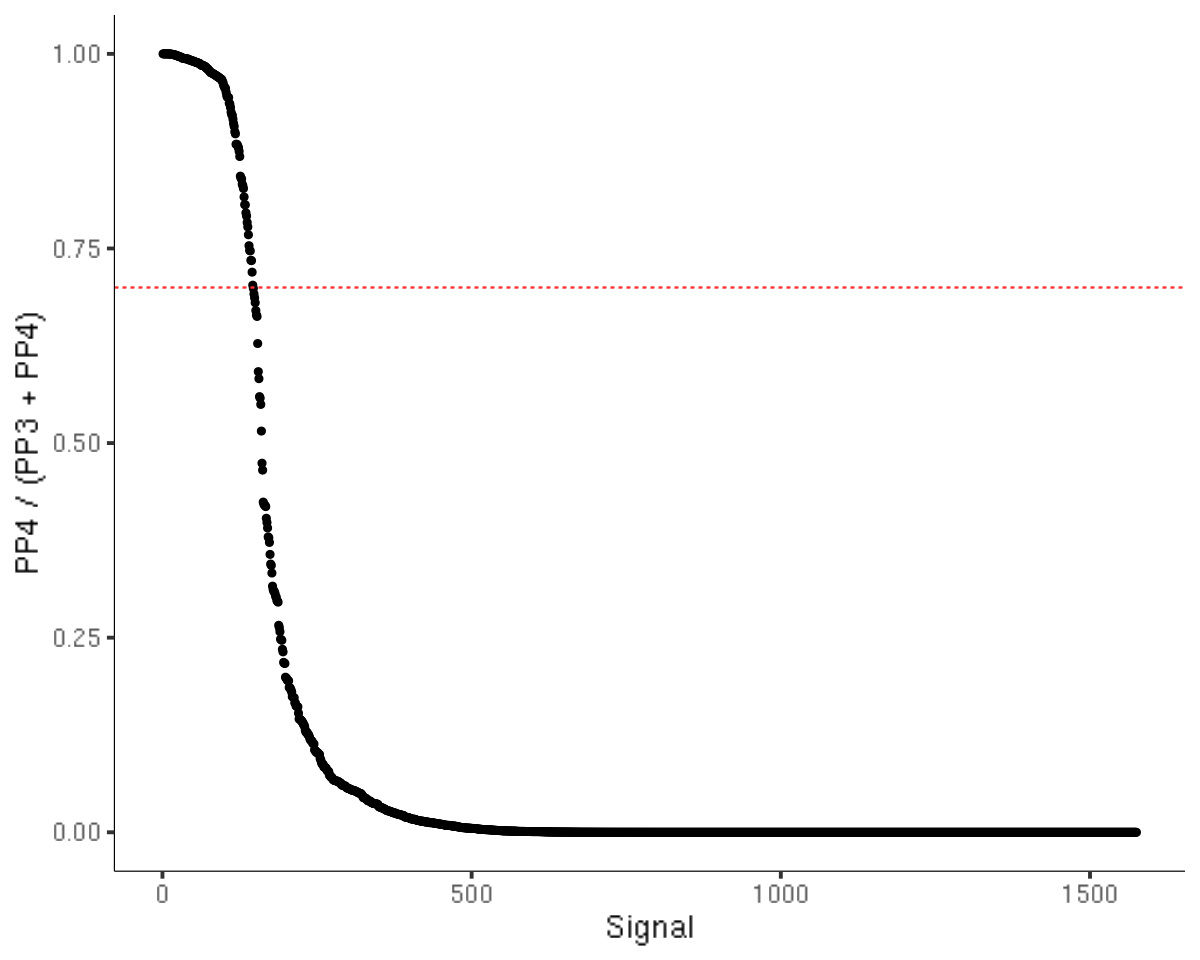

In [17]:
options(repr.plot.width=10, repr.plot.height=8)

coloc.res %>%
    dplyr::filter(PP.H3.abf + PP.H4.abf > 0.25) %>%
    dplyr::mutate(Coloc.Factor=PP.H4.abf / (PP.H3.abf + PP.H4.abf)) %>%
    dplyr::mutate(Rank=rank(-Coloc.Factor, ties.method="first")) %>%
    ggplot() +
    geom_point(aes(x=Rank, y=Coloc.Factor)) +
    geom_hline(aes(yintercept=0.7), lty=2, color="firebrick1") +
    xlab("Signal") + ylab("PP4 / (PP3 + PP4)") +
    ggplot_theme

In [18]:
colocalizing <- coloc.res %>%
    dplyr::filter(PP.H3.abf + PP.H4.abf > 0.25) %>%
    dplyr::mutate(Coloc.Factor=PP.H4.abf / (PP.H3.abf + PP.H4.abf)) %>%
    dplyr::filter(Coloc.Factor > 0.7) %>%
    dplyr::arrange(desc(Coloc.Factor))

In [19]:
head(colocalizing)

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Gene,eQTL.Signal,Eigengene,Module.QTL,Coloc.Factor
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2268,5.806199e-196,2.803456e-103,2.071086e-96,0,1,ENSG00000135404,1,ME_96,ME_96-12:54681479-56681478,1
2,2268,1.386873e-218,2.803456e-103,4.947011e-119,0,1,ENSG00000135424,1,ME_96,ME_96-12:54681479-56681478,1
3,2265,3.747055e-119,2.803456e-103,1.336584e-19,0,1,ENSG00000135437,1,ME_96,ME_96-12:54681479-56681478,1
4,2268,5.999961e-153,2.803456e-103,2.140202e-53,0,1,ENSG00000135441,1,ME_96,ME_96-12:54681479-56681478,1
5,2317,5.278947e-170,2.803456e-103,1.883014e-70,0,1,ENSG00000170439,1,ME_96,ME_96-12:54681479-56681478,1
6,2268,1.640296e-133,2.803456e-103,5.850979e-34,0,1,ENSG00000258056,1,ME_96,ME_96-12:54681479-56681478,1


There are 138 eGenes that colocalize with at least one module QTL. Of the 31 module QTL detected, 29 colocalize with at least one eGene. Module 104 @ Chr 15 and Module 86 @ Chr 4 are the two module QTL that do not colocalize with any *cis*-eQTL.

In [20]:
length(unique(colocalizing$Gene))

[1] 138

In [21]:
length(unique(colocalizing$Module.QTL))

[1] 29

In [22]:
setdiff(names(module.qtl.loci), colocalizing$Module.QTL)

[1] "ME_104-15:99550866-101595853" "ME_86-4:118205924-120759794"

## eGene Membership in Modules

In [43]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
rownames(modules) <- modules$Gene

In [55]:
egenes.in.module <- colocalizing %>%
    dplyr::mutate(Gene.Module = modules[Gene, "Module"]) %>%
    dplyr::mutate(Eigengene.Module = paste0("Module_", gsub("ME\\_", "", Eigengene))) %>%
    dplyr::select(Module.QTL, Gene.Module, Eigengene.Module) %>%
    dplyr::group_by(Module.QTL) %>%
    dplyr::summarize(
        eGene.In.Module=any(Gene.Module == Eigengene.Module),
        eGene.Not.In.Module=any(Gene.Module != Eigengene.Module)
    )
head(egenes.in.module)

Module.QTL,eGene.In.Module,eGene.Not.In.Module
<chr>,<lgl>,<lgl>
ME_101-1:24243590-26454176,TRUE,TRUE
ME_101-12:54985643-57091484,TRUE,TRUE
ME_102-17:17145294-19676395,TRUE,TRUE
ME_103-12:68275923-70364150,TRUE,FALSE
ME_105-6:36483138-38519496,TRUE,FALSE
ME_106-11:1-1332794,TRUE,TRUE


In [56]:
sum(egenes.in.module$eGene.In.Module)

[1] 25

In [57]:
sum(egenes.in.module$eGene.Not.In.Module)

[1] 19

In [58]:
egenes.in.module %>%
    dplyr::filter(!eGene.In.Module)

Module.QTL,eGene.In.Module,eGene.Not.In.Module
<chr>,<lgl>,<lgl>
ME_47-3:100304904-102512523,FALSE,TRUE
ME_71-3:100304904-102512523,FALSE,TRUE
ME_81-6:28644108-31488142,FALSE,TRUE
ME_84-6:29809721-33978544,FALSE,TRUE


## Colocalization Association Plots

In [23]:
geno <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/data/genotypes/eigengene_sva_ss_genotypes.raw", sep=" ", drop=2:6)
colnames(geno) <- gsub(":", "_", gsub("\\_.*", "", colnames(geno)))

geno <- as.data.frame(geno)
colnames(geno) <- gsub("X", "", colnames(geno))
rownames(geno) <- gsub("^GA", "", geno[, 1])
geno[, 1] <- NULL

In [24]:
module.egenes <- colocalizing %>%
    dplyr::mutate(eQTL=paste0(Gene, "-", eQTL.Signal)) %>%
    dplyr::select(eQTL, Module.QTL) %>%
    dplyr::group_by(Module.QTL) %>%
    dplyr::summarize(eQTL=paste0(eQTL, collapse=","))

module.egenes.map <- lapply(1:nrow(module.egenes), function(i) { unlist(strsplit(module.egenes$eQTL[i], ",")) })
names(module.egenes.map) <- module.egenes$Module.QTL

In [62]:
module.qtl = names(module.egenes.map)[7]
module.qtl

[1] "ME_47-3:100304904-102512523"

In [63]:
assoc <- dplyr::bind_rows(
    module.qtl.loci[[module.qtl]] %>%
        dplyr::select(snp, pos, p, qtl=module.qtl),
    do.call(rbind, cis.eqtl.loci[[module.qtl]]) %>%
        dplyr::select(snp=SNP, pos=Position, p=P_Value, qtl=ID) %>%
        dplyr::filter(qtl %in% module.egenes.map[[module.qtl]])
) %>%
    dplyr::mutate(log10p=-log10(p))

In [64]:
snp.set <- unique(assoc$snp)
ld <- cor(geno[,snp.set], use="pairwise.complete.obs")

ld.info <- do.call(rbind, assoc %>%
    dplyr::group_by(qtl) %>%
    dplyr::slice_min(p, n=1, with_ties=F) %>%
    apply(., 1, function(x) {
        as.data.frame(ld[, x[1]]) %>%
            dplyr::select(ld=1) %>%
            dplyr::mutate(snp=rownames(.), qtl=x[4], ld=ld^2)
    })
)

In [65]:
module.egenes.map[[module.qtl]]

[1] "ENSG00000138468-1" "ENSG00000081148-1"

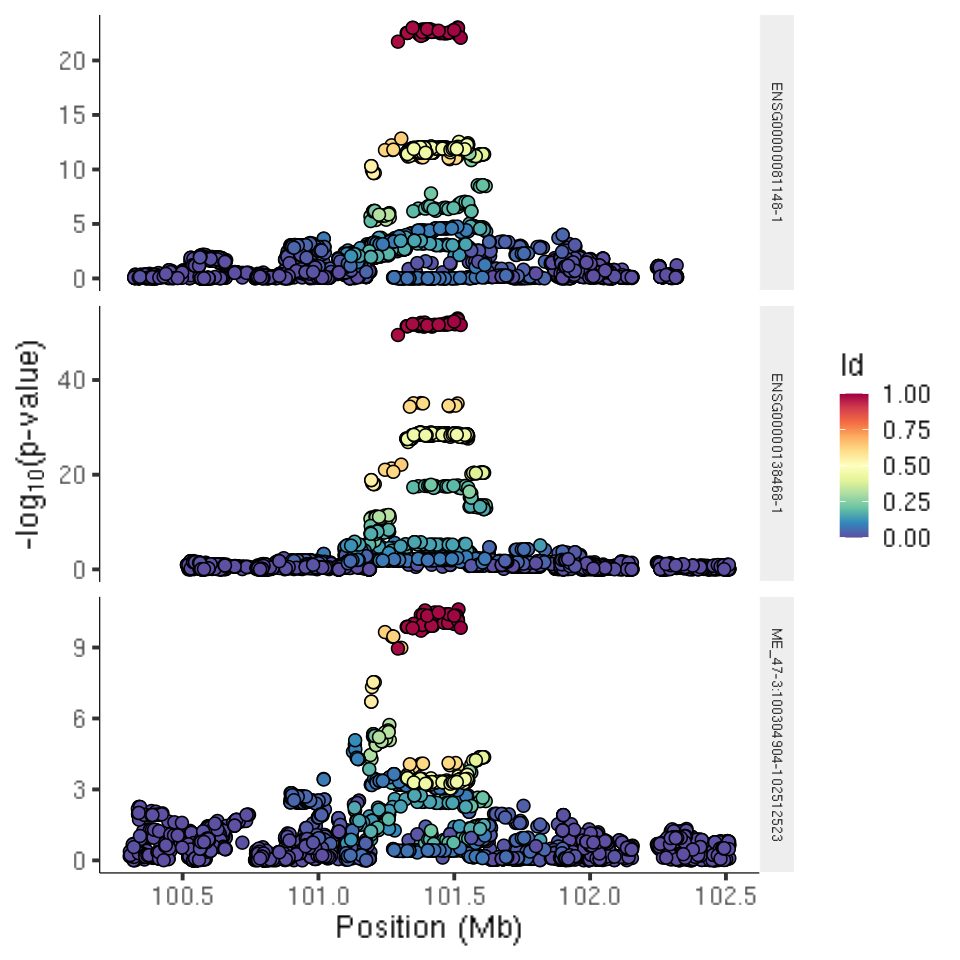

In [66]:
options(repr.plot.width=8, repr.plot.height=8)

palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(11, "Spectral")))

merge(assoc, ld.info, by=c("snp", "qtl")) %>%
    ggplot() +
    geom_point(aes(x=pos / 10^6, y=log10p, fill=ld), pch=21, size=3) +
    scale_fill_gradientn(colors=palette(100), limits=c(0, 1)) +
    xlab("Position (Mb)") + ylab(bquote("-log"[10]*"(p-value)")) +
    facet_grid(qtl ~ ., scales="free_y") +
    ggplot_theme +
    theme(legend.position="right", strip.text.y=element_text(size=8))